# New York City Parking Violations Analysis

In [2]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



## Import functions 

In [3]:
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import shapefile as shp
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
%matplotlib inline
connection=pymysql.connect(host='localhost', user='root', password='root', db='python_project')

## Violations spread over a week

In [3]:
Query1_1 = pd.read_sql("select dayname(`Issue Date`) as Day, count(*) as Counts from secondary_table group by dayname(`Issue Date`);", con=connection)
Query1_1 = Query1_1.set_index('Day')
Query1_1 = Query1_1.reindex(index=["Monday","Tuesday","Wednesday","Thursday", "Friday", "Saturday", "Sunday"])

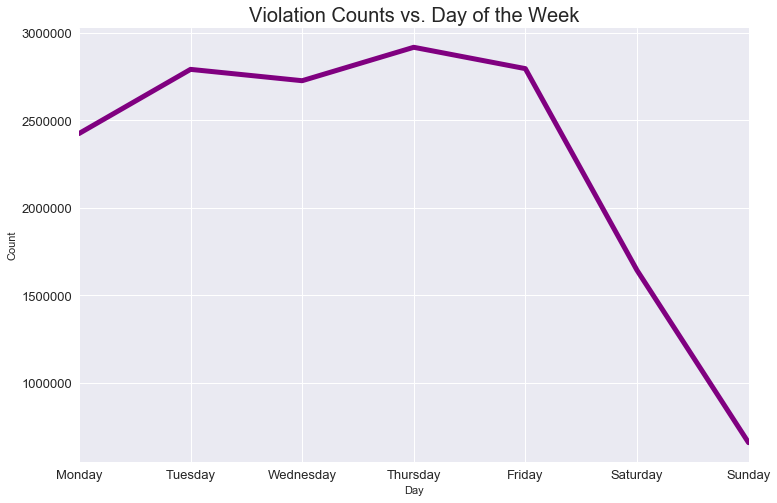

In [4]:
query1plot = Query1_1.plot(kind='line', legend=False, color='purple',
           title='Violation Counts vs. Day of the Week', grid=True, figsize=(12,8), linewidth=5, fontsize=13)
query1plot.set_title('Violation Counts vs. Day of the Week', fontsize=20)
query1plot.set_ylabel('Count')

## Violations spread over the years

In [5]:
connection=pymysql.connect(host='localhost', user='root', password='root', db='python_project')
df_sql = pd.read_sql('select count(*) AS freq,monthname(`Issue Date`) AS m ,year(`Issue Date`) AS y from secondary_table group by monthname(`Issue Date`),year(`Issue Date`);', con=connection)

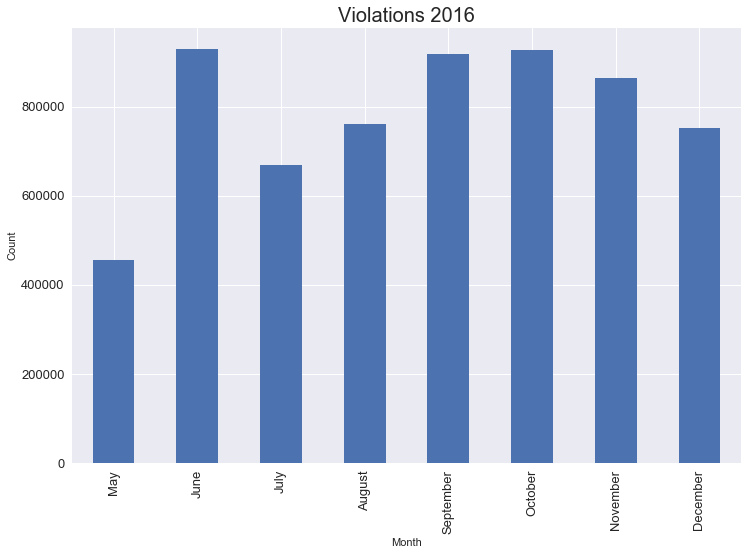

In [6]:
## Violations in 2016
df_2016 = df_sql[df_sql['y'] == 2016]
df_test2016 = df_2016.set_index('m')
df_ordered_2016 = df_test2016.reindex(index = ['May','June','July','August','September','October','November','December'])
ordered2016plot = df_ordered_2016.plot(kind='bar', y = 0, title = "Violations 2016", figsize=(12,8), legend=False, fontsize=13)
ordered2016plot.set_xlabel('Month')
ordered2016plot.set_title('Violations 2016', fontsize=20)
ordered2016plot.set_ylabel('Count')

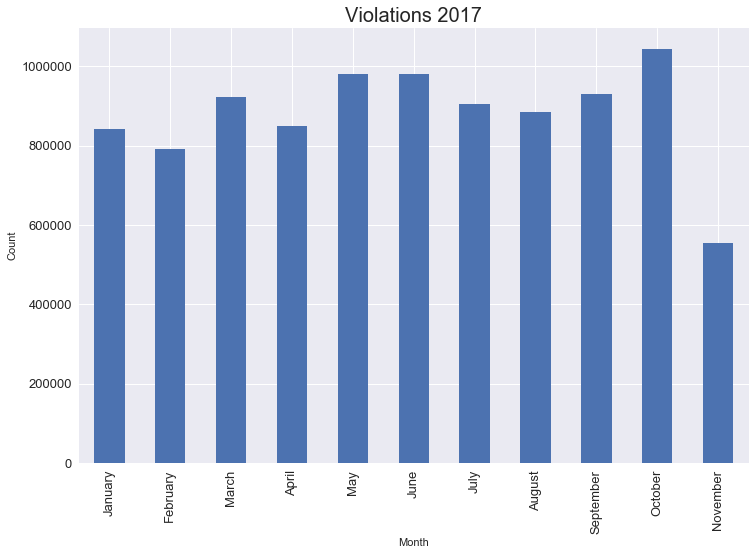

In [7]:
## Violations in 2017
df_2017 = df_sql[df_sql['y']==2017]
df_test2017 = df_2017.set_index('m')
df_ordered_2017 = df_test2017.reindex(index = ['January','February','March','April','May','June','July','August','September','October','November'])
ordered2017plot = df_ordered_2017.plot(kind='bar', y = 0, title = "Violations 2017", figsize=(12,8), legend=False, fontsize=13)
ordered2017plot.set_xlabel('Month')
ordered2017plot.set_title('Violations 2017', fontsize=20)
ordered2017plot.set_ylabel('Count')

## Precincts Analysis

In [8]:
origQuery3_1 = pd.read_sql('select Precinct, count(*) as Counts from secondary_table group by Precinct;', con=connection)

In [9]:
Query3_1 = origQuery3_1
Query3_1.Precinct = Query3_1.Precinct.astype(int)

In [10]:
precinctstoplot=pd.read_csv('C:/Users/amitk/Documents/Homework Assignments/Chandola/Project/Most up to date datasets/Support_files/precincttoplot.csv')
precinctstoplot.Precinct = precinctstoplot.Precinct.astype(int)

In [11]:
coloringIDs = pd.merge(Query3_1, precinctstoplot, on='Precinct')

In [12]:
coloringIDs.loc[-1] = [1000, 0, 12]  # adding a row
coloringIDs.index = coloringIDs.index + 1  # shifting index

In [13]:
coloringIDs=coloringIDs.set_index('PlotID')

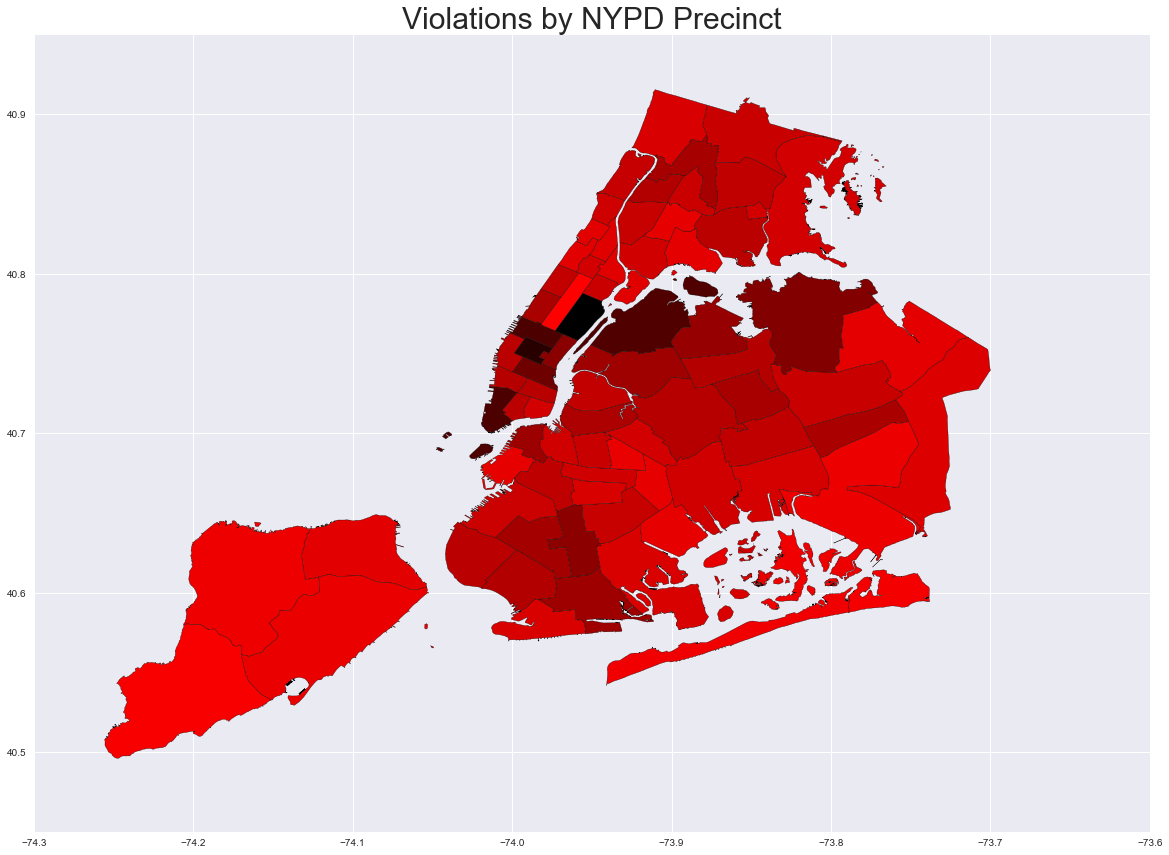

In [14]:
## ADD LEGEND

# Code Adapted From
# https://chrishavlin.wordpress.com/2016/11/16/shapefiles-tutorial/
# https://chrishavlin.wordprtubless.com/2016/12/01/shapely-polygons-coloring/

myshp = open("C:/Users/amitk/Documents/Homework Assignments/Chandola/Project/Most up to date datasets/Support_files/nyc.shp", "rb")
mydbf = open("C:/Users/amitk/Documents/Homework Assignments/Chandola/Project/Most up to date datasets/Support_files/nyc.dbf", "rb")
r = shp.Reader(shp=myshp, dbf=mydbf)
plt.figure(figsize=(20,20))
ax = plt.axes() # add the axes
ax.set_aspect('equal')
#for shape in list(r.iterShapes()):
i=-1
for shape in list(r.iterShapes()):
    i+=1
    # define polygon fill color (facecolor) RGB values:
    R = 1-(coloringIDs.loc[i][1]/coloringIDs.Counts.max())
    G = 0
    B = 0
    
    # check number of parts (could use MultiPolygon class of shapely?)
    nparts = len(shape.parts) # total parts
    if nparts == 1:
       polygon = Polygon(shape.points)
       patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
       ax.add_patch(patch)

    else: # loop over parts of each shape, plot separately
      for ip in range(nparts): # loop over parts, plot separately
          i0=shape.parts[ip]
          if ip < nparts-1:
             i1 = shape.parts[ip+1]-1
          else:
             i1 = len(shape.points)

          polygon = Polygon(shape.points[i0:i1+1])
          patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
          ax.add_patch(patch)

plt.xlim(-74.3,-73.6)
plt.ylim(40.45,40.95)
plt.title('Violations by NYPD Precinct', fontsize='30')
plt.show()

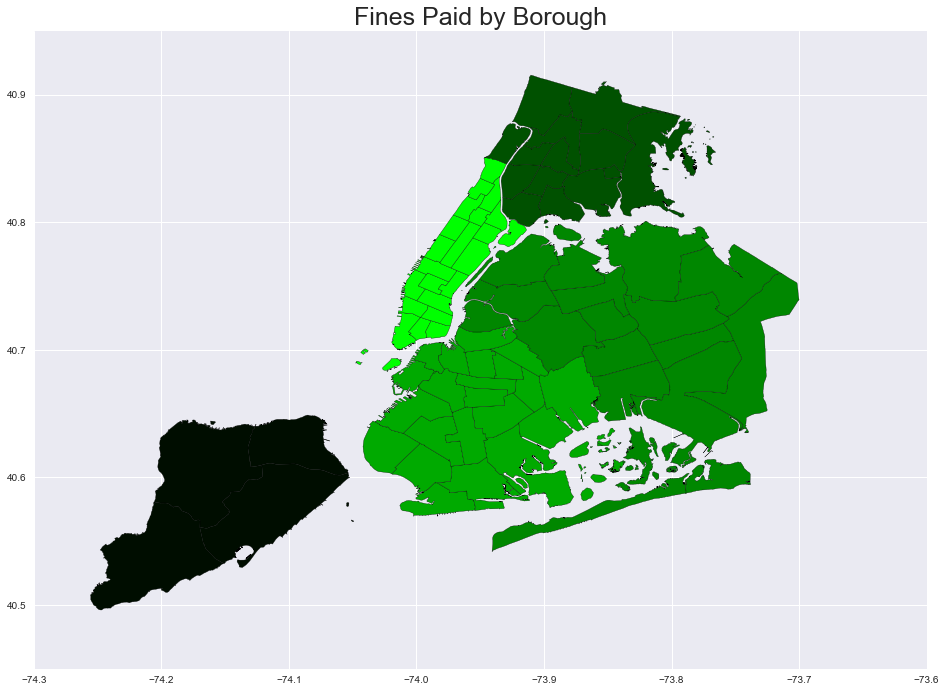

In [15]:
origQuery10_1 = pd.read_sql('select County, count(*) as Counts, sum(`Fine Amount`) as `Fine Sum` from secondary_table group by county',
                       con = connection)

Query10_1 = origQuery10_1

Bronx = Query10_1.iloc[1:3,]
Brooklyn = Query10_1.iloc[[0,3,4],]
Manhattan = Query10_1.iloc[[5,7],]
Queens = Query10_1.iloc[8:11,]
StatenIsland = Query10_1.iloc[11:,]
d = {'Counts': [Bronx.sum()[1], Brooklyn.sum()[1], Manhattan.sum()[1], Queens.sum()[1], StatenIsland.sum()[1]],
     'Total Fines': [Bronx.sum()[2], Brooklyn.sum()[2], Manhattan.sum()[2], Queens.sum()[2], StatenIsland.sum()[2]]}
totalFines = pd.DataFrame(data=d, index=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])
totalFines

## ADD LEGEND

# Code Adapted From
# https://chrishavlin.wordpress.com/2016/11/16/shapefiles-tutorial/
# https://chrishavlin.wordprtubless.com/2016/12/01/shapely-polygons-coloring/

myshp = open("C:/Users/amitk/Documents/Homework Assignments/Chandola/Project/Most up to date datasets/Support_files/nyc.shp", "rb")
mydbf = open("C:/Users/amitk/Documents/Homework Assignments/Chandola/Project/Most up to date datasets/Support_files/nyc.dbf", "rb")
r = shp.Reader(shp=myshp, dbf=mydbf)
plt.figure(figsize=(16,16))
ax = plt.axes() # add the axes
ax.set_aspect('equal')

icolor = 1
#for shape in list(r.iterShapes()):
i=-1
for shape in list(r.iterShapes()):
    i+=1
    # define polygon fill color (facecolor) RGB values:
    R = 1
    G = 1
    B = 1
    if i in range(21): # Manhattan
        R=0
        G=totalFines.iloc[2,1]/totalFines['Total Fines'].max()
        B=0
    elif i in range(34): # Bronx
        R=0
        G=totalFines.iloc[0,1]/totalFines['Total Fines'].max()
        B=0
    elif i in range(56): # Brooklyn
        R=0
        G=totalFines.iloc[1,1]/totalFines['Total Fines'].max()
        B=0
    elif i in range(73): # Queens
        R=0
        G=totalFines.iloc[3,1]/totalFines['Total Fines'].max()
        B=0
    else:                 # Staten Island
        R=0
        G=totalFines.iloc[4,1]/totalFines['Total Fines'].max()
        B=0
    
    # check number of parts (could use MultiPolygon class of shapely?)
    nparts = len(shape.parts) # total parts
    if nparts == 1:
       polygon = Polygon(shape.points)
       patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
       ax.add_patch(patch)

    else: # loop over parts of each shape, plot separately
      for ip in range(nparts): # loop over parts, plot separately
          i0=shape.parts[ip]
          if ip < nparts-1:
             i1 = shape.parts[ip+1]-1
          else:
             i1 = len(shape.points)

          polygon = Polygon(shape.points[i0:i1+1])
          patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
          ax.add_patch(patch)

    icolor = icolor + 1

plt.xlim(-74.3,-73.6)
plt.ylim(40.45,40.95)
plt.title('Fines Paid by Borough', fontsize='25')
plt.show()

In [21]:
p = {'Counts': [Bronx.sum()[1], Brooklyn.sum()[1], Manhattan.sum()[1], Queens.sum()[1], StatenIsland.sum()[1]],
     'Total Fines, Millions': [Bronx.sum()[2], Brooklyn.sum()[2], Manhattan.sum()[2], Queens.sum()[2], StatenIsland.sum()[2]]}
totalFines_p = pd.DataFrame(data=p, index=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])
totalFines_p['Total Fines, Millions'] = totalFines_p['Total Fines, Millions']/1000000
totalFines_p


,Counts,"Total Fines, Millions"
Bronx,2065241,140.940688
Brooklyn,4665933,295.527984
Manhattan,5029148,443.211059
Queens,3775884,233.891163
Staten Island,376001,22.912121


## Average Fines by Boroughs

In [22]:
averages = {'Average Fine': [Bronx.sum()[2]/Bronx.sum()[1], Brooklyn.sum()[2]/Brooklyn.sum()[1],
                            Manhattan.sum()[2]/Manhattan.sum()[1],Queens.sum()[2]/Queens.sum()[1],
                             StatenIsland.sum()[2]/StatenIsland.sum()[1]]}
averageFines = pd.DataFrame(data=averages, index=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])
averageFines

,Average Fine
Bronx,68.244185
Brooklyn,63.337383
Manhattan,88.128458
Queens,61.943419
Staten Island,60.936330


## Top 10 Violating States Excluding New York

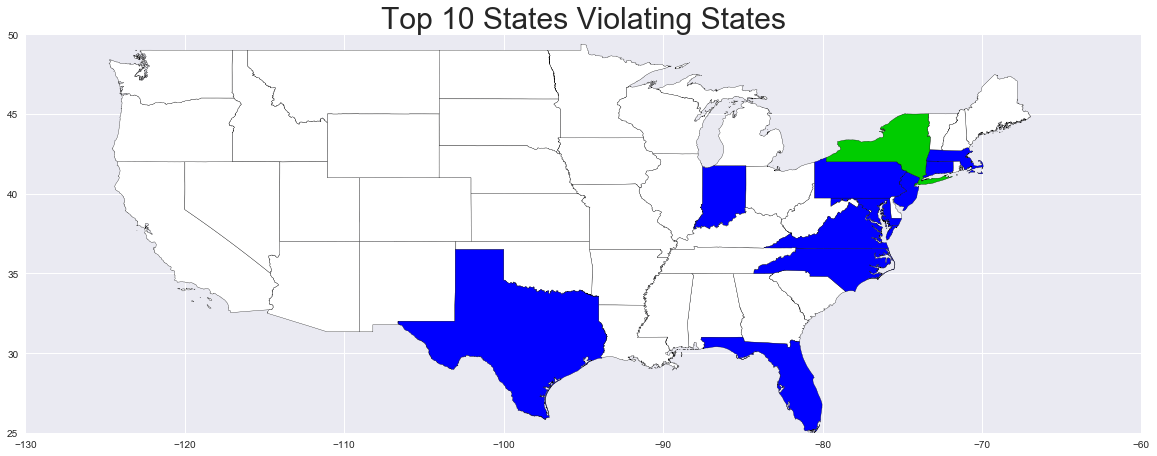

In [23]:
myshp2 = open("C:/Users/amitk/Documents/Homework Assignments/Chandola/Project/Most up to date datasets/Support_files/cb_2016_us_state_500k.shp", "rb")
mydbf2 = open("C:/Users/amitk/Documents/Homework Assignments/Chandola/Project/Most up to date datasets/Support_files/cb_2016_us_state_500k.dbf", "rb")
s = shp.Reader(shp=myshp2, dbf=mydbf2)
plt.figure(figsize=(20,20))
ax = plt.axes() # add the axes
ax.set_aspect('equal')

i=-1
for shape in list(s.iterShapes()):
    #shape = list(s.iterShapes())[2]
    i+=1
    # define polygon fill color (facecolor) RGB values:
    R = 1
    G = 1
    B = 1
    if i in [21,25,34,6,13,38,50,16,44,49]:
        R = 0
        G = 0
    elif i in [43]:
        R = 0
        G = .8
        B = 0
    # check number of parts (could use MultiPolygon class of shapely?)
    nparts = len(shape.parts) # total parts
    if nparts == 1:
       polygon = Polygon(shape.points)
       patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
       ax.add_patch(patch)

    else: # loop over parts of each shape, plot separately
      for ip in range(nparts): # loop over parts, plot separately
          i0=shape.parts[ip]
          if ip < nparts-1:
             i1 = shape.parts[ip+1]-1
          else:
             i1 = len(shape.points)

          polygon = Polygon(shape.points[i0:i1+1])
          patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
          ax.add_patch(patch)

    ###############
    plt.xlim(-130,-60)
    plt.ylim(25,50)
    plt.title('Top 10 States Violating States', fontsize='30')
plt.show()

## Share of tickets collected among 4 most prominent Departments

In [24]:
connection=pymysql.connect(host='localhost', user='root', password='root', db='python_project')
df_sql_agency = pd.read_sql('select count(*) AS freq, agency from MasterData group by agency;', con=connection)

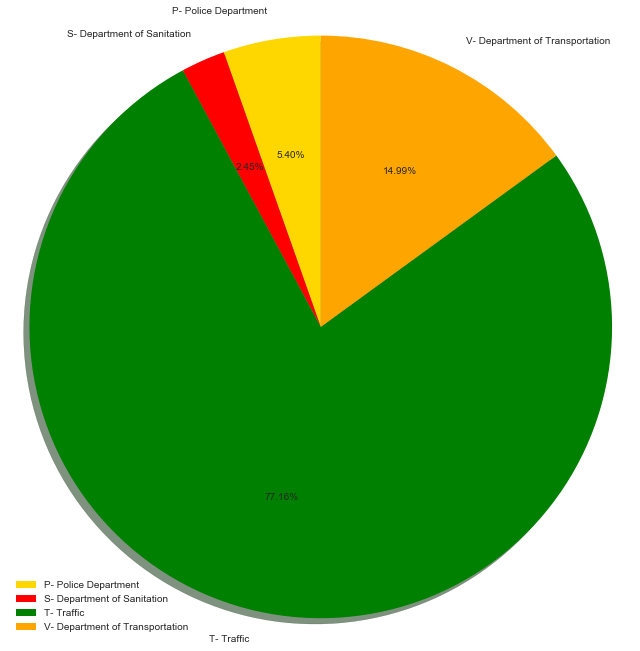

In [25]:
labels = ['P- Police Department','S- Department of Sanitation','T- Traffic','V- Department of Transportation'] 
sizes = df_sql_agency['freq'] 
colors = ["Gold", "red", "green", "Orange"]
plt.figure(figsize=(9,9))
plt.pie([209092,94766,2986611,580071], labels = labels,
    shadow=True,
    colors=colors,
    startangle=90,
    autopct='%.2f%%',
    )
plt.axis('equal')
plt.legend(labels, loc="best")
plt.tight_layout()
plt.show()

## Top 10 criminal states other than NY

In [37]:
origQuery3_2 = pd.read_sql('select State, sum(`Fine Amount`) as `fine` from secondary_table group by state order by State desc limit 11;'
                      , con=connection)

In [38]:
Query3_2 = origQuery3_2

In [39]:
Query3_2 = Query3_2.set_index('State')

In [41]:
Query3_2

,fine
State,
WY,38930.0
WV,274080.0
WI,476035.0
WA,664275.0
VT,781190.0
VA,7682985.0
UT,124785.0
TX,4437085.0
TN,1742719.0


# Violations per State Plate top 10

In [32]:
origQuery9_1 = pd.read_sql('select State, count(*) AS `Violations Statewise` from secondary_table group by state order by  desc limit 10;', con=connection)

In [33]:
Query9_1 = origQuery9_1
Query9_1 = Query9_1.drop(0)
Query9_1


,State,Violations Statewise
1,WV,3857
2,WI,6415
3,WA,9852
4,VT,11255
5,VA,109141
6,UT,1792
7,TX,59985
8,TN,26178
9,SK,40


## Most prevalent Violations (Top 10)

In [36]:
origQuery12_1 = pd.read_sql(' select Violation, count(*) AS ViolationsCount from secondary_table group by Violation order by ViolationsCount desc limit 10;', con=connection)

In [47]:
Query12_1 = origQuery12_1

In [48]:
Query12_1.set_index('No of Violations')

,Violation
No of Violations,
2324160,NO PARKING-STREET CLEANING
2007469,PHTO SCHOOL ZN SPEED VIOLATION
1645648,FAIL TO DSPLY MUNI METER RECPT
1388941,NO STANDING-DAY/TIME LIMITS
954818,NO PARKING-DAY/TIME LIMITS
813389,INSP. STICKER-EXPIRED/MISSING
807595,EXPIRED MUNI METER
799276,FIRE HYDRANT
753083,FAILURE TO STOP AT RED LIGHT


## Top 20 cars that break the law

In [21]:
origQuery11_1 = pd.read_sql('select count(*) AS Number_oF_Violations, vehmake AS Brand from masterdata group by Brand order by Number_of_violations desc limit 10;', con = connection)

In [ ]:
Query11_1 = origQuery11_1

In [ ]:
Query11_1.set_index('Number_oF_Violations')

## Brandwise Fines

In [12]:
origQuery13_1 = pd.read_sql('select sum(`Fine Amount`) fine,vehMake from masterdata join secondary_table on masterdata.summonsNo=secondary_table.`Summons Number` group by vehMake order by fine desc limit 10;', con = connection)

In [13]:
Query13_1 = origQuery13_1

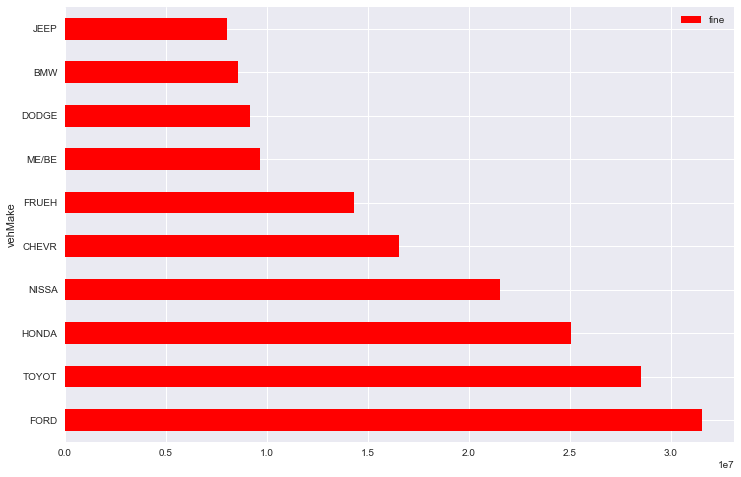

In [20]:
Query13_1.set_index('vehMake').plot(kind='barh',color='Red',figsize=(12,8))

In [22]:
origQuery14_1 = pd.read_sql('select month(IssueDate) as Month,Violation as V,count(*) from masterdata join secondary_table on masterdata.summonsNo=secondary_table.`Summons Number` group by Month,V;', con = connection)

In [24]:
Query14_1 = origQuery14_1

0                           CROSSWALK
1                      DOUBLE PARKING
2                        FIRE HYDRANT
3       INSP. STICKER-EXPIRED/MISSING
4      NGHT PKG ON RESID STR-COMM VEH
5          NO PARKING-DAY/TIME LIMITS
6       NO PARKING-EXC. AUTH. VEHICLE
7          NO PARKING-STREET CLEANING
8                NO STANDING-BUS LANE
9                NO STANDING-BUS STOP
10        NO STANDING-DAY/TIME LIMITS
11     NO STANDING-EXC. AUTH. VEHICLE
12     NO STANDING-EXC. TRUCK LOADING
13               OBSTRUCTING DRIVEWAY
14                    PEDESTRIAN RAMP
15                           SIDEWALK
16                          BIKE LANE
17                     DOUBLE PARKING
18                       FIRE HYDRANT
19        FRONT OR BACK PLATE MISSING
20      INSP. STICKER-EXPIRED/MISSING
21     NGHT PKG ON RESID STR-COMM VEH
22       NIGHTTIME STD/ PKG IN A PARK
23         NO PARKING-DAY/TIME LIMITS
24         NO PARKING-STREET CLEANING
25               NO STANDING-BUS STOP
26        NO

In [35]:
vio=["NO PARKING-STREET CLEANING",
"PHTO SCHOOL ZN SPEED VIOLATION",
"FAIL TO DSPLY MUNI METER RECPT",
"NO STANDING-DAY/TIME LIMITS",
"NO PARKING-DAY/TIME LIMITS",
"INSP. STICKER-EXPIRED/MISSING",
"EXPIRED MUNI METER",
"FIRE HYDRANT",
"FAILURE TO STOP AT RED LIGHT",
"DOUBLE PARKING"]
m=[5,6,7,8,9,10]

In [55]:
Query14_1=Query14_1[Query14_1['V'].isin(vio)]
Query14_1=Query14_1[Query14_1['Month'].isin(m)]
c=Query14_1['count(*)'].tolist()

In [63]:
Query14_1

,Month,V,count(*)
76,5,DOUBLE PARKING,149
78,5,EXPIRED MUNI METER,3
79,5,FAIL TO DSPLY MUNI METER RECPT,10
80,5,FIRE HYDRANT,102
82,5,INSP. STICKER-EXPIRED/MISSING,10
87,5,NO PARKING-DAY/TIME LIMITS,120
90,5,NO PARKING-STREET CLEANING,28
94,5,NO STANDING-DAY/TIME LIMITS,241
123,6,DOUBLE PARKING,10838
128,6,EXPIRED MUNI METER,5483
